# Model Assessment

In this analysis, we'll use a case study looking at an individual's email habits.

We hypothesize that there are two types of emails that arrive in a person's inbox and require a response:

1. Those that have no task associated other than to reply with an immediately available piece of information
2. Those that require a task to be accomplished before they can be replied to.

The outflow of the first of these types of emails can be modeled as a first order delay on their inflow, which would be equivalent to assuming that email sending and email checking follow a poisson process, and the time between message arrival and the next inbox check follows an exponential distribution. 

The second type can be modeled as a higher order delay, as the 'task' associated with the email's arrival first must be acted upon and then written about.

### SD Model
Such a model would look something like this:

![Model Screenshot](../../models/Emails/full_model.png)

Normally, emails would arrive over a period of time, and would be responded to continuously, and the distribution itself would get all mixed up in the day to day fluctuations. However, if we time-shift the arrival of each email to arrive at time 0, then the output of each of these stocks will represent the distribution of time between arrival and reply to each type of message. To do this we create a 1-timestep pulse input with the full volume of the messages, and build our delay around these values:

```
Easy Arrival=
	Easy Email Volume / TIME STEP * PULSE(0, TIME STEP )
    
Easy Reply= 
	DELAY N(Easy Arrival, Easy Reply Time, 0, 1)    
```

Below we see how the sum of replies to easy and hard emails creates a distribution of response times.

In [1]:
%pylab inline
import pysd
import pandas as pd
import scipy.optimize

Populating the interactive namespace from numpy and matplotlib


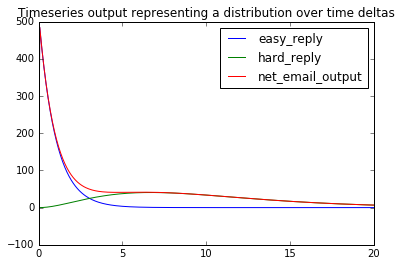

In [3]:
model = pysd.read_vensim('../../models/Emails/Emails_in_2_fixed_categories.mdl')
params = {'total_emails':1000,
          'easy_fraction':.5,
          'easy_reply_time':1,
          'hard_reply_time':10}

model.run(params,
          return_columns=['net_email_output', 'easy_reply', 'hard_reply']).plot()
plt.title('Timeseries output representing a distribution over time deltas')
plt.xlim(0,20);

### Data
Now our task will be to compare this output distribution with data collected on response times from an actual inbox. In this case, mine. The data comes (from our [data processing script](http://www.jamesphoughton.com/2016/02/06/Email-Data-Formatter.html)) with a single time delta per row, so we take a histogram to get a distribution we can compare with model output.

As we've taken a histogram bin size of 1 day, then the height of the bins themselves represents the number of messages per day we can expect to come out of our model. If we changed the bins size, we would need to scale these values to preserve the units.

Loaded 1403 conversations


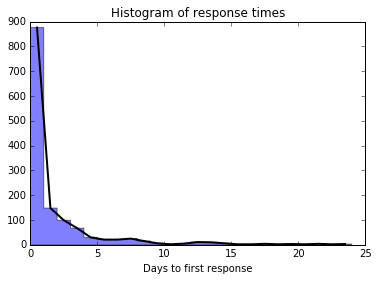

In [4]:
response_times = pd.read_csv('../../data/Emails/days_to_join_conversation.csv', 
                             names=['id','Days'], index_col='id')
num_conversations = len(response_times)
print 'Loaded %i conversations'%num_conversations

counts, edges, _ = plt.hist(response_times['Days'], bins=range(25), 
                            histtype='stepfilled', alpha=.5)
data = pd.Series(data=counts, 
                 index=1.*(edges[:-1]+edges[1:])/2) #take the average location in the bin

data.plot(linewidth=2, color='k', xlim=(0,25), 
          title='Histogram of response times');
plt.xlabel('Days to first response');

### Fitting

Our task is now to fit the model output to the observed distribution. To do this we'll construct a helper function to take an array of parameters (which the optimizer provides), run the model, and calculate the sum of squared errors between the model output and the data distribution.

In [30]:
param_names = ['easy_fraction', 'easy_reply_time', 'hard_reply_time']

def error(param_list, data, num_conversations):
    params = dict(zip(param_names, param_list))
    params['total_emails'] = num_conversations
    
    #run the model with the new parameters, returning the info we're interested in
    result = model.run(params=params,
                       return_columns=['net_email_output'],
                       return_timestamps=list(data.index.values))
    
    #the sum of the squared errors
    sse = sum((result['net_email_output'] - data)**2)
    return sse

error([.5, .5, 20], data, num_conversations)

128962.22585551594

Fitting is relatively straightforward, we pass the error function to scipy's optimizer, with a few bounds, and an initial guess.

In [35]:
params = {'easy_fraction':.8,
          'easy_reply_time':1.1,
          'hard_reply_time':7}

bounds = {'easy_fraction':[0.001,.999],
          'easy_reply_time':[0.001,21],
          'hard_reply_time':[.001,52]}

res = scipy.optimize.minimize(error, [params[key] for key in param_names],
                              args=(data, num_conversations),
                              method='L-BFGS-B',#'L-BFGS-B', #'SLSQP', #'TNC'
                              bounds=[bounds[key] for key in param_names])
res

   status: 0
  success: True
     nfev: 512
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      fun: 10986.275201802197
        x: array([  0.84894292,   0.71866884,  20.6090577 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
      jac: array([  9946.84851321,  31919.28553861,     95.6661097 ])
      nit: 12

### Plotting the result

The fit parameters can be seen below, with the calculated data distribution in black. 

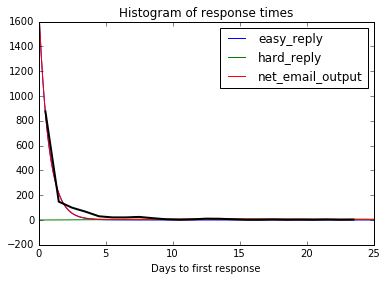

In [36]:
params=dict(zip(param_names, res['x']))
params['total_emails'] = num_conversations

model.run(params,
          return_columns=['net_email_output', 'easy_reply', 'hard_reply']).plot()

data.plot(linewidth=2, color='k', xlim=(0,25), 
          title='Histogram of response times');
plt.xlabel('Days to first response');